In [1]:
import numpy as np
import if2 as if2
from scipy.stats import norm
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import pandas as pd

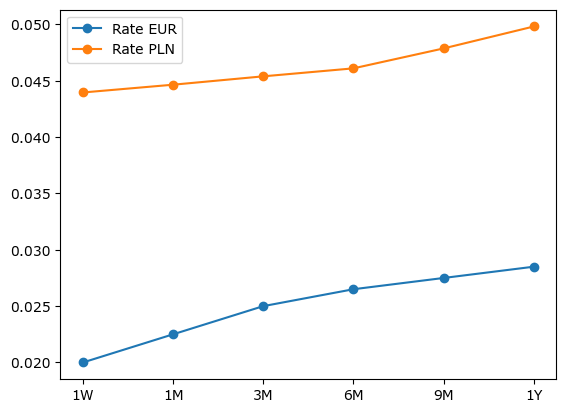

In [2]:
# Dane
FXspot = 4.3420
FXspotData=np.linspace(FXspot-1,FXspot+1,100)
tenor = ["1W", "1M", "3M", "6M", "9M", "1Y"]
yf = [1/52, 1/12, 3/12, 6/12, 9/12, 1]
rate_ccy = [0.02, 0.0225, 0.025, 0.0265, 0.0275, 0.0285]
swapp = [20, 80, 220, 420, 650, 900]

data = pd.DataFrame({"tenor":tenor, "yf": yf, "rate_ccy": rate_ccy, "swapp": swapp})
cc_curves = if2.cc_imp_curves(FXspot,data.tenor,data.yf,data.rate_ccy,data.swapp)

rate_pln = cc_curves[5]
df_pln   = cc_curves[4]
rate_eur = cc_curves[3]
df_eur   = cc_curves[2]
plt.plot(tenor,rate_eur,marker='o',label="Rate EUR")
plt.plot(tenor,rate_pln,marker='o',label="Rate PLN")
plt.legend()

In [3]:
# Definiowanie strategii z opcji waniliowych i binarnych
def strategia1(S,lista_opcji):
    payout=0.0
    for opcja in lista_opcji:
        opt_type,poz,N,cp,K = opcja
        if poz.upper() in ("LONG","BUY"):
            poz_val = 1.0
        elif poz.upper() in ("SHORT","SELL"):
            poz_val = -1.0
        if cp.upper() in ("CALL"):
            omega = 1.0
        elif cp.upper() in ("PUT"):
            omega = -1.0   
        if opt_type == "V": 
            payout += poz_val*N*if2.VanillaPay(omega,S,K)
        elif opt_type == "B":
            payout += poz_val*N*if2.BinaryPay(omega,S,K)
    return payout

In [4]:
# Wyznaczanie wartości strategii z opcji waniliowych i binarnych
def Strategia_value(fx_spot,df_ccy_t,df_pln_t,tau,strategy,strategy_spec_parm):
    val=0.0
  #  for (opcja,opcja_parm) in (strategy,strategy_spec_parm):
    for k in range(len(strategy)):    
        opt_type,poz,nominal,cp,K  = strategy[k]
        sigma,strike               = strategy_spec_parm[k]
        if poz.upper() in ("LONG","BUY"):
            poz_val = 1.0
        elif poz.upper() in ("SHORT","SELL"):
            poz_val = -1.0
        if cp.upper() in ("CALL"):
            omega = 1.0
        elif cp.upper() in ("PUT"):
            omega = -1.0   
        if opt_type == "V": 
            val += poz_val*if2.BS_value(fx_spot,df_ccy_t,df_pln_t,tau,sigma,omega,strike,nominal)
        elif opt_type == "B":
            val += poz_val*if2.BS_Binary(omega, FXspot, sigma, df_pln_t, df_ccy_t, strike, tau, nominal,"nonbase")
    return val

In [5]:
# Wyznaczanie Vegi strategii z opcji waniliowych
def Strategia_Vega(fx_spot,df_ccy_t,df_pln_t,tau,strategy,strategy_spec_parm):
    val=0.0
  #  for (opcja,opcja_parm) in (strategy,strategy_spec_parm):
    for k in range(len(strategy)):    
        opt_type,poz,nominal,cp,K  = strategy[k]
        sigma,strike               = strategy_spec_parm[k]
        if poz.upper() in ("LONG","BUY"):
            poz_val = 1.0
        elif poz.upper() in ("SHORT","SELL"):
            poz_val = -1.0
        if cp.upper() in ("CALL"):
            omega = 1.0
        elif cp.upper() in ("PUT"):
            omega = -1.0   
        if opt_type == "V": 
            val += poz_val*if2.VegaBS(fx_spot,sigma,df_ccy_t,df_pln_t,strike,tau,nominal)
        elif opt_type == "B":
            val += 0.0
    return val

In [6]:
FXspot = 4.3240
dni    = 92
T      = dni/365.0
df_pln_T = if2.int_df(T,yf,df_pln)
df_eur_T = if2.int_df(T,yf,df_eur)
vol_ATM = 0.055
vol_RR  = 0.0093
vol_BF  = 0.0021
spot_fwd="fwd"
prem_incl="std"

# ATM Strike
omega = 1
delta = 0.5
K_ATM=if2.StrikeFromDelta(spot_fwd,prem_incl,omega,delta,FXspot,vol_ATM,df_pln_T,df_eur_T,T)

# STRADDLE Strikes
omega = 1
delta = 0.25
vol_25_STRG  = vol_ATM + vol_BF
K_25C_STRG = if2.StrikeFromDelta(spot_fwd,prem_incl,omega,delta,FXspot,vol_25_STRG,df_pln_T,df_eur_T,T)
omega = -1
delta = -0.25
vol_25_STRG = vol_ATM + vol_BF
K_25P_STRG = if2.StrikeFromDelta(spot_fwd,prem_incl,omega,delta,FXspot,vol_25_STRG,df_pln_T,df_eur_T,T)

# RR Strikes
omega = 1
delta = 0.25
vol_25C_RR = vol_ATM + 0.5*vol_RR + vol_BF # if RR favours Calls
K_25C_RR = if2.StrikeFromDelta(spot_fwd,prem_incl,omega,delta,FXspot,vol_25C_RR,df_pln_T,df_eur_T,T)
omega = -1
delta = -0.25
vol_25P_RR = vol_ATM - 0.5*vol_RR + vol_BF # if RR favours Calls
K_25P_RR = if2.StrikeFromDelta(spot_fwd,prem_incl,omega,delta,FXspot,vol_25P_RR,df_pln_T,df_eur_T,T)

print(f"K_ATM                      : {K_ATM: 6.4f}")
print(f"K_25C_STRG                 : {K_25C_STRG: 6.4f}")
print(f"K_25P_STRG                 : {K_25P_STRG: 6.4f}")
print(f"0.5(K_25P_STRG+K_25C_STRG) : {0.5*(K_25P_STRG+K_25C_STRG): 6.4f}")
print(f"K_25C_RR                   : {K_25C_RR: 6.4f}")
print(f"K_25P_RR                   : {K_25P_RR: 6.4f}")
print(f"0.5(K_25P_RR+K_25C_RR)     : {0.5*(K_25P_RR+K_25C_RR): 6.4f}")

K_ATM                      :  4.3477
K_25C_STRG                 :  4.4327
K_25P_STRG                 :  4.2646
0.5(K_25P_STRG+K_25C_STRG) :  4.3487
K_25C_RR                   :  4.4400
K_25P_RR                   :  4.2710
0.5(K_25P_RR+K_25C_RR)     :  4.3555


# ATM Straddle

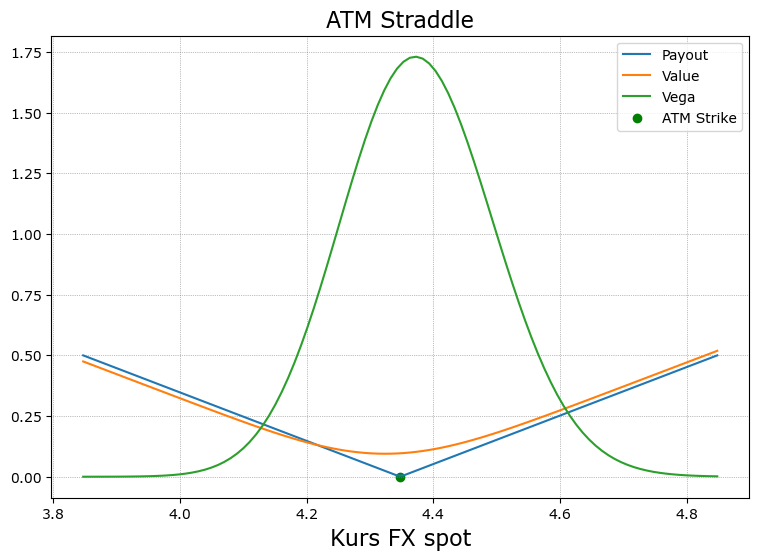

In [7]:
FXspotData=np.linspace(K_ATM-0.5,K_ATM+0.5,100)

#ATM Straddle
Opcja_1 = ("V","long",1.0,"call",K_ATM)     # (opt_type,poz,N,call_put,Strike)
Opcja_2 = ("V","long",1.0,"put", K_ATM)
Opcja_1_parm = (vol_ATM,K_ATM)
Opcja_2_parm = (vol_ATM,K_ATM)
atm_straddle = (Opcja_1,Opcja_2)
atm_straddle_parm = (Opcja_1_parm,Opcja_2_parm)

fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("ATM Straddle",fontsize=16)
axl.set_xlabel("Kurs FX spot",fontsize=16)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FXspotData,[strategia1(FXspot,atm_straddle) for FXspot in FXspotData],label="Payout")
plt.plot(FXspotData,[Strategia_value(FXspot,df_eur_T,df_pln_T,T,atm_straddle,atm_straddle_parm) for FXspot in FXspotData],label='Value')
plt.plot(FXspotData,[Strategia_Vega(FXspot,df_eur_T,df_pln_T,T,atm_straddle,atm_straddle_parm) for FXspot in FXspotData],label='Vega')
plt.scatter(K_ATM,strategia1(K_ATM,atm_straddle),color="green",label='ATM Strike')
plt.legend()

# Strangle

Uwaga: Kurs ATM  4.3477 nie lezy po środku między K_25P_STRG  4.2646 a K_25C_STRG  4.4327
Środek między K_25P_STRG a K_25C_STRG jest w  4.3487


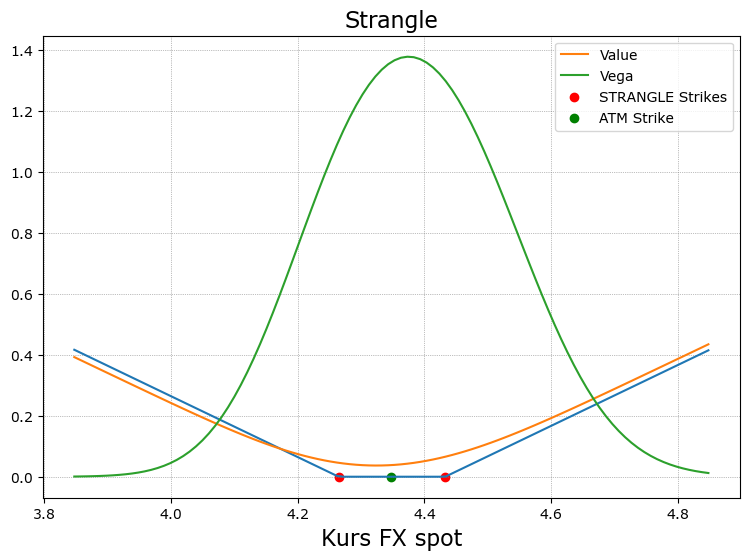

In [8]:
FXspotData=np.linspace(K_ATM-0.5,K_ATM+0.5,100)

#Strangle
Opcja_1 = ("V","long",1,"call",K_25C_STRG)   # (opt_type,poz,N,call_put,Strike)
Opcja_2 = ("V","long",1,"put", K_25P_STRG)
Opcja_1_parm = (vol_25_STRG,K_25C_STRG)
Opcja_2_parm = (vol_25_STRG,K_25P_STRG)
strangle = (Opcja_1,Opcja_2)
strangle_parm = (Opcja_1_parm,Opcja_2_parm)

fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Strangle",fontsize=16)
axl.set_xlabel("Kurs FX spot",fontsize=16)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FXspotData,[strategia1(FXspot,strangle) for FXspot in FXspotData])
plt.plot(FXspotData,[Strategia_value(FXspot,df_eur_T,df_pln_T,T,strangle,strangle_parm) for FXspot in FXspotData],label='Value')
plt.plot(FXspotData,[Strategia_Vega(FXspot,df_eur_T,df_pln_T,T,strangle,strangle_parm) for FXspot in FXspotData],label='Vega')
plt.scatter((K_25P_STRG,K_25C_STRG),(0,0),color="red",label='STRANGLE Strikes')
plt.scatter(K_ATM,0,color="green",label='ATM Strike')
plt.legend()
print(f"Uwaga: Kurs ATM {K_ATM: 6.4f} nie lezy po środku między K_25P_STRG {K_25P_STRG: 6.4f} a K_25C_STRG {K_25C_STRG: 6.4f}")
print(f"Środek między K_25P_STRG a K_25C_STRG jest w {0.5*(K_25C_STRG+K_25P_STRG): 6.4f}")

# Risk Reversal

Uwaga: Kurs ATM  4.3477 nie lezy po środku między K_25P_RR  4.2710 a K_25C_RR  4.4400
Środek między K_25P_RR a K_25C_RR jest w  4.3555


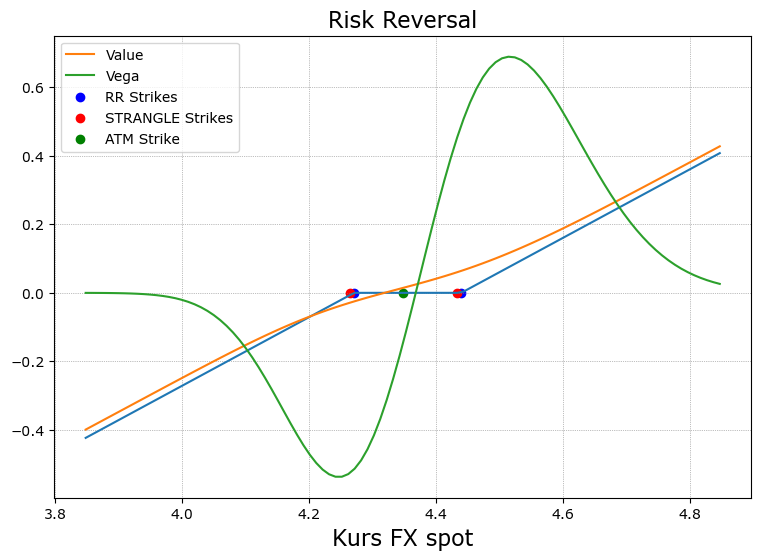

In [9]:
FXspotData=np.linspace(K_ATM-0.5,K_ATM+0.5,100)

#Risk Reversal
Opcja_1 = ("V","short",1,"put",K_25P_RR)   # (opt_type,poz,N,call_put,Strike)
Opcja_2 = ("V","long",1,"call",K_25C_RR)
Opcja_1_parm = (vol_25P_RR,K_25P_RR)
Opcja_2_parm = (vol_25C_RR,K_25C_RR)
risk_reversal = (Opcja_1,Opcja_2)
risk_reversal_parm = (Opcja_1_parm,Opcja_2_parm)

fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Risk Reversal",fontsize=16)
axl.set_xlabel("Kurs FX spot",fontsize=16)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FXspotData,[strategia1(FXspot,risk_reversal) for FXspot in FXspotData])
plt.plot(FXspotData,[Strategia_value(FXspot,df_eur_T,df_pln_T,T,risk_reversal,risk_reversal_parm) for FXspot in FXspotData],label='Value')
plt.plot(FXspotData,[Strategia_Vega(FXspot,df_eur_T,df_pln_T,T,risk_reversal,risk_reversal_parm) for FXspot in FXspotData],label='Vega')
plt.scatter((K_25P_RR,K_25C_RR),(0,0),color="blue",label='RR Strikes')
plt.scatter((K_25P_STRG,K_25C_STRG),(0,0),color="red",label='STRANGLE Strikes')
plt.scatter(K_ATM,0,color="green",label='ATM Strike')
plt.legend()
print(f"Uwaga: Kurs ATM {K_ATM: 6.4f} nie lezy po środku między K_25P_RR {K_25P_RR: 6.4f} a K_25C_RR {K_25C_RR: 6.4f}")
print(f"Środek między K_25P_RR a K_25C_RR jest w {0.5*(K_25C_RR+K_25P_RR): 6.4f}")

# Badanie wrazliwości RR przy zmianie zmienności ATM, RR, BF

In [10]:
dvol = 0.001
RR_val     = Strategia_value(FXspot,df_eur_T,df_pln_T,T,risk_reversal,risk_reversal_parm)
Vega_C    = if2.VegaBS(FXspot, vol_25C_RR, df_pln_T, df_eur_T, K_25C_RR, T, 1)
Vega_P    = if2.VegaBS(FXspot, vol_25P_RR, df_pln_T, df_eur_T, K_25P_RR, T, 1)
Opcja_1_parm_dvol = (vol_25P_RR-0.5*dvol,K_25P_RR)
Opcja_2_parm_dvol = (vol_25C_RR+0.5*dvol,K_25C_RR)
risk_reversal_parm_dvol = (Opcja_1_parm_dvol,Opcja_2_parm_dvol)
RR_val_dRR = Strategia_value(FXspot,df_eur_T,df_pln_T,T,risk_reversal,risk_reversal_parm_dvol)
print(f"Zmiana wartości RR przy zmianie RR_vol o {100*dvol} p.p. wynosi: {RR_val_dRR-RR_val: 8.6f}")
print(f"Vega RR jako Vega_Call wynosi {Vega_C: 6.4f}")
print(f"Vega RR jako Vega_Put  wynosi {Vega_P: 6.4f}")
print(f"Zmiana wartości RR obliczona jako Vega {Vega_C: 6.4f} x zmiana RR_vol o {100*dvol} p.p. wynosi: {Vega_C*dvol: 8.6f}")

Zmiana wartości RR przy zmianie RR_vol o 0.1 p.p. wynosi:  0.000685
Vega RR jako Vega_Call wynosi  0.6855
Vega RR jako Vega_Put  wynosi  0.6855
Zmiana wartości RR obliczona jako Vega  0.6855 x zmiana RR_vol o 0.1 p.p. wynosi:  0.000686


# Butterfly

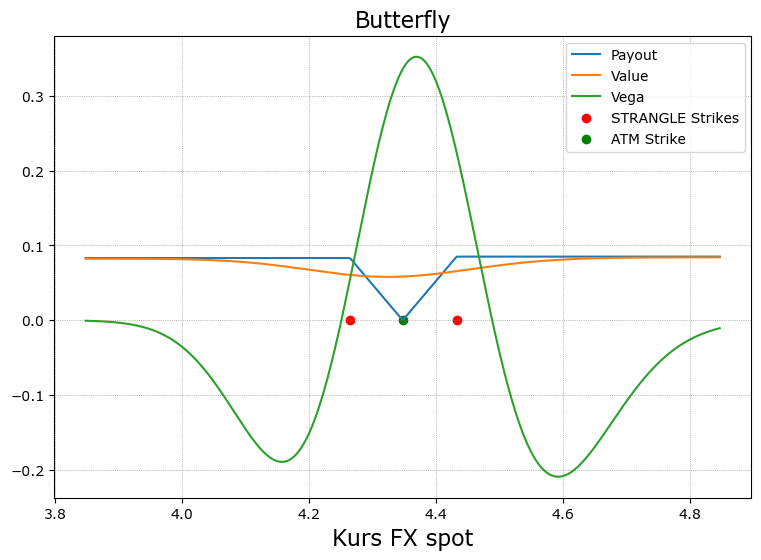

In [11]:
FXspotData=np.linspace(K_ATM-0.5,K_ATM+0.5,300)

# Long ATM Straddle
Opcja_1 = ("V","long",1,"call",K_ATM)    # (opt_type,poz,N,call_put,Strike)
Opcja_2 = ("V","long",1,"put", K_ATM)
# Short 25D Strangle 
Opcja_3 = ("V","short", 1,"call",K_25C_STRG)
Opcja_4 = ("V","short", 1,"put", K_25P_STRG)
Vega_25C    = if2.VegaBS(FXspot, vol_25_STRG, df_pln_T, df_eur_T, K_25C_STRG, T, 1)
Vega_25P    = if2.VegaBS(FXspot, vol_25_STRG, df_pln_T, df_eur_T, K_25P_STRG, T, 1)
Opcja_1_parm = (vol_ATM,K_ATM)
Opcja_2_parm = (vol_ATM,K_ATM)
Opcja_3_parm = (vol_25_STRG,K_25C_STRG)
Opcja_4_parm = (vol_25_STRG,K_25P_STRG)
butterfly = (Opcja_1,Opcja_2,Opcja_3,Opcja_4)
butterfly_parm = (Opcja_1_parm,Opcja_2_parm,Opcja_3_parm,Opcja_4_parm)

#Opcja_3_parm_dvol = (vol_25_STRG+dvol,K_25C_STRG)
#Opcja_4_parm_dvol = (vol_25_STRG+dvol,K_25P_STRG)
#batterfly_parm_dvol = (Opcja_1_parm,Opcja_2_parm,Opcja_3_parm_dvol,Opcja_4_parm_dvol)

fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Butterfly",fontsize=16)
axl.set_xlabel("Kurs FX spot",fontsize=16)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FXspotData,[strategia1(FXspot,butterfly) for FXspot in FXspotData],label="Payout")
plt.plot(FXspotData,[Strategia_value(FXspot,df_eur_T,df_pln_T,T,butterfly,butterfly_parm) for FXspot in FXspotData],label='Value')
plt.plot(FXspotData,[Strategia_Vega(FXspot,df_eur_T,df_pln_T,T,butterfly,butterfly_parm) for FXspot in FXspotData],label='Vega')
plt.scatter((K_25P_STRG,K_25C_STRG),(0,0),color="red",label='STRANGLE Strikes')
plt.scatter(K_ATM,0,color="green",label='ATM Strike')
plt.legend()

# Vega Weighted Butterfly (VW-BF)

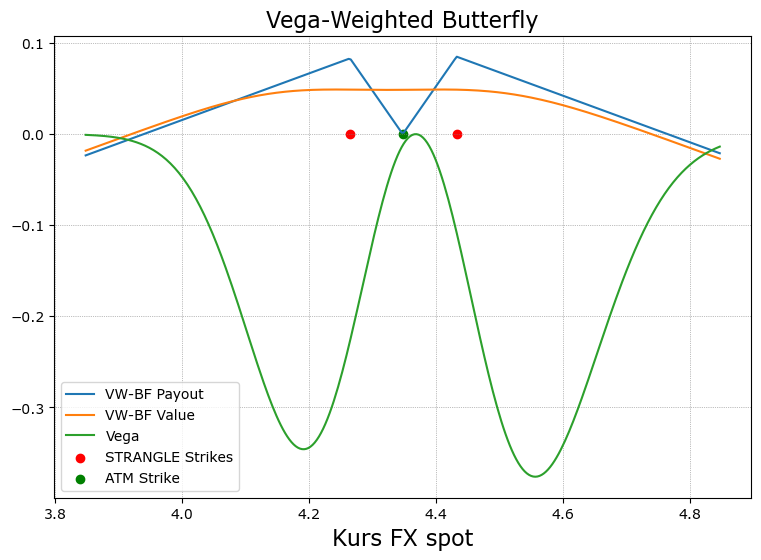

In [12]:
FXspotData=np.linspace(K_ATM-0.5,K_ATM+0.5,300)

# Long ATM Straddle
Opcja_1 = ("V","long",1,"call",K_ATM)    # (opt_type,poz,N,call_put,Strike)
Opcja_2 = ("V","long",1,"put", K_ATM)
Vega_C_STRD = if2.VegaBS(FXspot, vol_ATM, df_pln_T, df_eur_T, K_ATM, T, 1)
# Short 25D Strangle 
Opcja_3 = ("V","short", 1,"call",K_25C_STRG)
Opcja_4 = ("V","short", 1,"put", K_25P_STRG)
Vega_25C    = if2.VegaBS(FXspot, vol_25_STRG, df_pln_T, df_eur_T, K_25C_STRG, T, 1)
Vega_25P    = if2.VegaBS(FXspot, vol_25_STRG, df_pln_T, df_eur_T, K_25P_STRG, T, 1)
beta = Vega_C_STRD/Vega_25C
Opcja_3 = ("V","short", beta,"call",K_25C_STRG)
Opcja_4 = ("V","short", beta,"put", K_25P_STRG)
Opcja_1_parm = (vol_ATM,K_ATM)
Opcja_2_parm = (vol_ATM,K_ATM)
Opcja_3_parm = (vol_25_STRG,K_25C_STRG)
Opcja_4_parm = (vol_25_STRG,K_25P_STRG)
butterfly = (Opcja_1,Opcja_2,Opcja_3,Opcja_4)
butterfly_parm = (Opcja_1_parm,Opcja_2_parm,Opcja_3_parm,Opcja_4_parm)

fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Vega-Weighted Butterfly",fontsize=16)
axl.set_xlabel("Kurs FX spot",fontsize=16)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FXspotData,[strategia1(FXspot,butterfly) for FXspot in FXspotData],label="VW-BF Payout")
plt.plot(FXspotData,[Strategia_value(FXspot,df_eur_T,df_pln_T,T,butterfly,butterfly_parm) for FXspot in FXspotData],label='VW-BF Value')
plt.plot(FXspotData,[Strategia_Vega(FXspot,df_eur_T,df_pln_T,T,butterfly,butterfly_parm) for FXspot in FXspotData],label='Vega')
plt.scatter((K_25P_STRG,K_25C_STRG),(0,0),color="red",label='STRANGLE Strikes')
plt.scatter(K_ATM,0,color="green",label='ATM Strike')
plt.legend()

# Badanie zmiany wartości VW-BF przy zmianie zmienności ATM, BF

In [13]:
dvol = 0.001
BF_val     = Strategia_value(FXspot,df_eur_T,df_pln_T,T,butterfly,butterfly_parm)

# Long ATM Straddle
Opcja_1 = ("V","long",1,"call",K_ATM)    # (opt_type,poz,N,call_put,Strike)
Opcja_2 = ("V","long",1,"put", K_ATM)
Vega_C_STRD = if2.VegaBS(FXspot, vol_ATM, df_pln_T, df_eur_T, K_ATM, T, 1)
# Short 25D Strangle 
Vega_25C    = if2.VegaBS(FXspot, vol_25_STRG, df_pln_T, df_eur_T, K_25C_STRG, T, 1)
Vega_25P    = if2.VegaBS(FXspot, vol_25_STRG, df_pln_T, df_eur_T, K_25P_STRG, T, 1)
beta = Vega_C_STRD/Vega_25C
Opcja_3 = ("V","short", beta,"call",K_25C_STRG)
Opcja_4 = ("V","short", beta,"put", K_25P_STRG)
Opcja_1_parm = (vol_ATM,K_ATM)
Opcja_2_parm = (vol_ATM,K_ATM)
Opcja_3_parm = (vol_25_STRG,K_25C_STRG)
Opcja_4_parm = (vol_25_STRG,K_25P_STRG)
Opcja_1_parm_dvol = (vol_ATM,K_ATM)
Opcja_2_parm_dvol = (vol_ATM,K_ATM)
Opcja_3_parm_dvol = (vol_25_STRG+dvol,K_25C_STRG)
Opcja_4_parm_dvol = (vol_25_STRG+dvol,K_25P_STRG)
butterfly = (Opcja_1,Opcja_2,Opcja_3,Opcja_4)
batterfly_parm_dvol = (Opcja_1_parm_dvol,Opcja_2_parm_dvol,Opcja_3_parm_dvol,Opcja_4_parm_dvol)
BF_val         = Strategia_value(FXspot,df_eur_T,df_pln_T,T,butterfly,butterfly_parm)
BF_val_dvol    = Strategia_value(FXspot,df_eur_T,df_pln_T,T,butterfly,batterfly_parm_dvol)
print(f"Vega ATM Call w STRD wynosi {Vega_C_STRD: 6.4f}")
print(f"Vega 25 Call w STRG wynosi  {Vega_25C: 6.4f}")
print(f"Vega 25 Put w STRG  wynosi  {Vega_25P: 6.4f}")
print(f"Beta - ilość STRG w Vega-Weighted BF - wynosi: {beta: 4.2f}")
print(f"Zmiana wartości BF przy zmianie STRG_vol o {100*dvol} p.p. wynosi: {BF_val_dvol-BF_val: 8.6f}")
print(f"Zmiana wartości BF obliczona jako Vega beta*STRG {-2.0*beta*Vega_25C: 6.4f} x zmiana BF_vol o {100*dvol} p.p. wynosi: {-2.0*beta*Vega_25C*dvol: 8.6f}")

Vega ATM Call w STRD wynosi  0.8606
Vega 25 Call w STRG wynosi   0.6855
Vega 25 Put w STRG  wynosi   0.6855
Beta - ilość STRG w Vega-Weighted BF - wynosi:  1.26
Zmiana wartości BF przy zmianie STRG_vol o 0.1 p.p. wynosi: -0.001728
Zmiana wartości BF obliczona jako Vega beta*STRG -1.7212 x zmiana BF_vol o 0.1 p.p. wynosi: -0.001721


# Call z europejską barierią

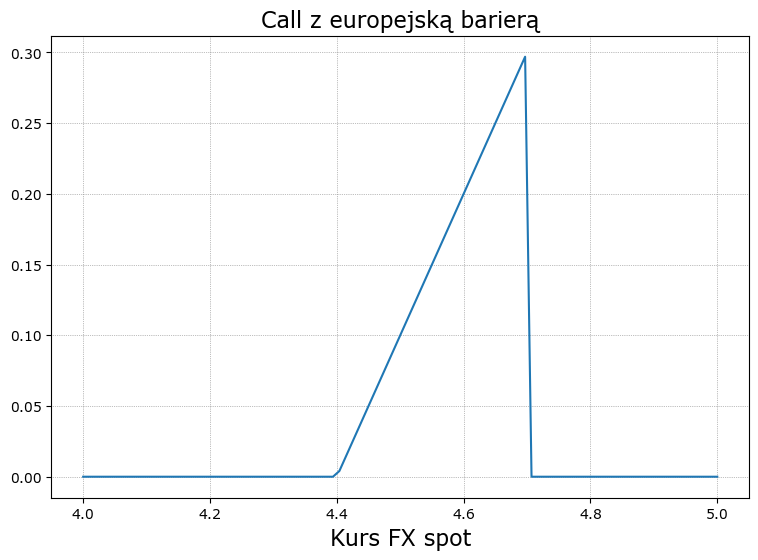

In [14]:
FXspot = 4.5
FXspotData=np.linspace(FXspot-0.5,FXspot+0.5,100)

K = 4.40
B = 4.70
#call z europejską barierią
Opcja_1 = ("V","long",1,"call",K)    # (opt_type,poz,N,call_put,Strike)
Opcja_2 = ("V","short",1,"call",B)
Opcja_3 = ("B","short",B-K,"call",B)
call_barrier = (Opcja_1,Opcja_2,Opcja_3)

fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Call z europejską barierą",fontsize=16)
axl.set_xlabel("Kurs FX spot",fontsize=16)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FXspotData,[strategia1(FXspot,call_barrier) for FXspot in FXspotData])

# Call spread

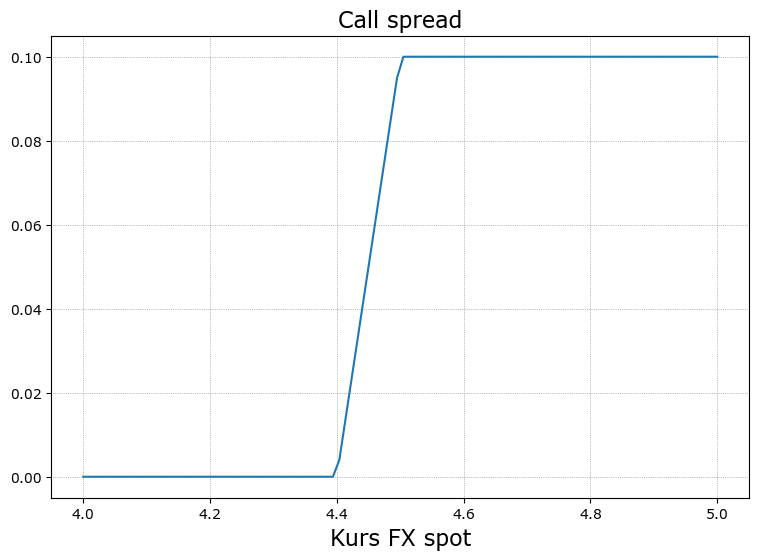

In [15]:
FXspot = 4.5
FXspotData=np.linspace(FXspot-0.5,FXspot+0.5,100)

K1 = 4.40
K2 = 4.50
#call spread
Opcja_1 = ("V","long", 1,"call",K1)    # (opt_type,poz,N,call_put,Strike)
Opcja_2 = ("V","short",1,"call",K2)
call_spread = (Opcja_1,Opcja_2)

fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Call spread",fontsize=16)
axl.set_xlabel("Kurs FX spot",fontsize=16)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FXspotData,[strategia1(FXspot,call_spread) for FXspot in FXspotData])

# Call spread jako replikacja opcji binarnej call

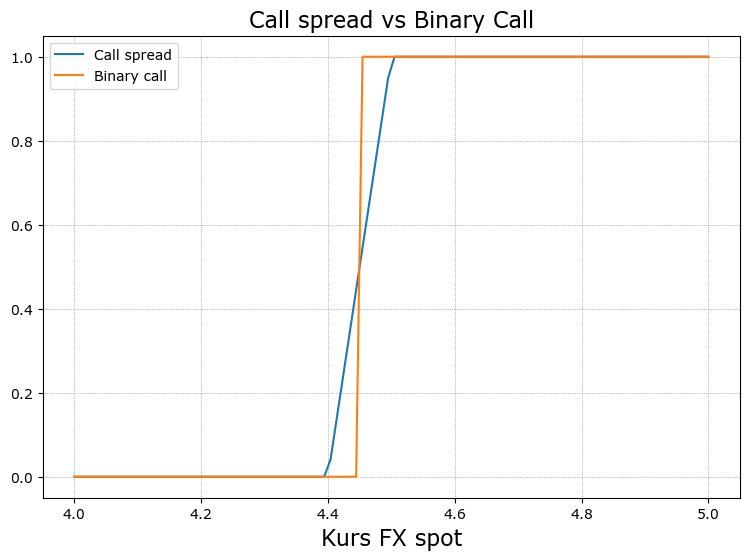

In [16]:
FXspot = 4.5
FXspotData=np.linspace(FXspot-0.5,FXspot+0.5,100)

K1 = 4.40
K2 = 4.50
#call spread
Opcja_1 = ("V","long", 1,"call",K1)    # (opt_type,poz,N,call_put,Strike)
Opcja_2 = ("V","short",1,"call",K2)
call_spread = (Opcja_1,Opcja_2)

fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Call spread vs Binary Call",fontsize=16)
axl.set_xlabel("Kurs FX spot",fontsize=16)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FXspotData,[strategia1(FXspot,call_spread)/(K2-K1) for FXspot in FXspotData],label="Call spread")
plt.plot(FXspotData,[if2.BinaryPay(1,FXspot,0.5*(K1+K2)) for FXspot in FXspotData],label="Binary call")
plt.legend()

0.12894711538461537


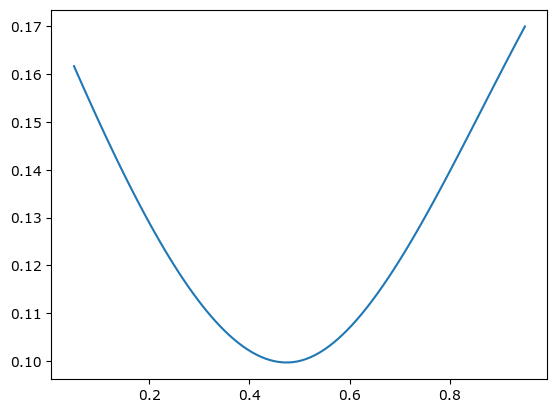

In [17]:
deltas=[0.10,0.25,0.5,0.75,0.90]
vols=[0.15,0.12,0.10,0.13,0.16]
intCS=CubicSpline(deltas,vols)
vol=intCS(0.2)
print(vol)
delta_ax=np.linspace(0.05,0.95,100)
plt.plot(delta_ax,intCS(delta_ax))

0.052648794871794864


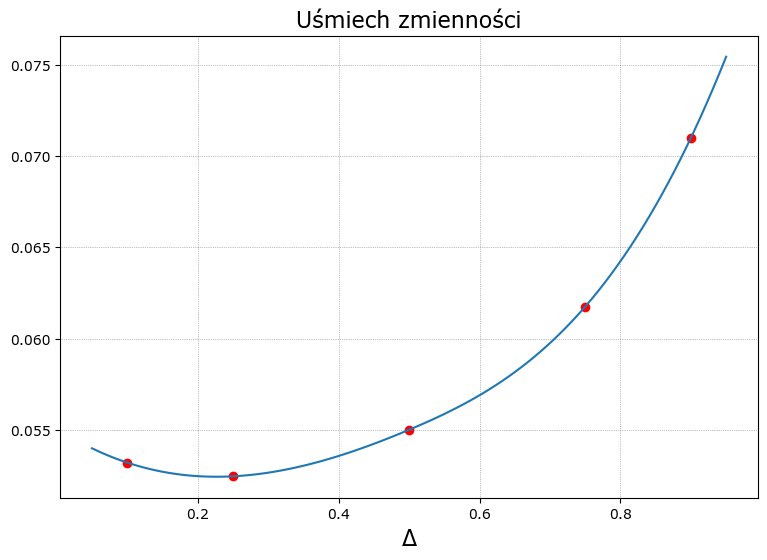

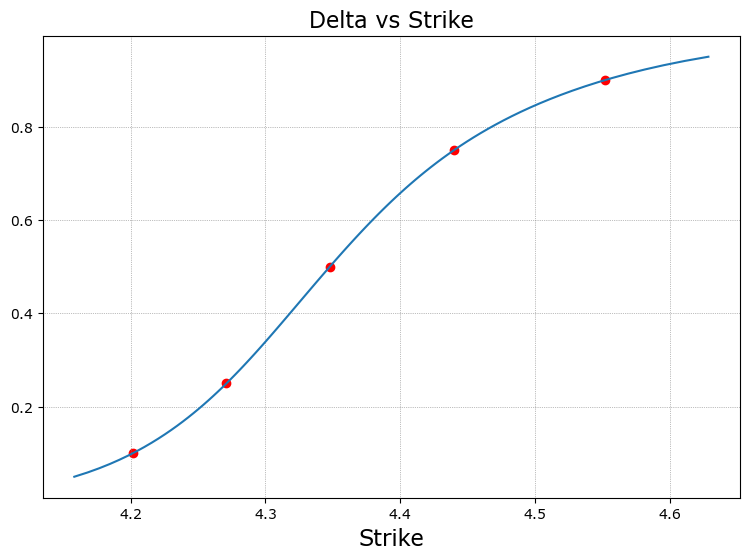

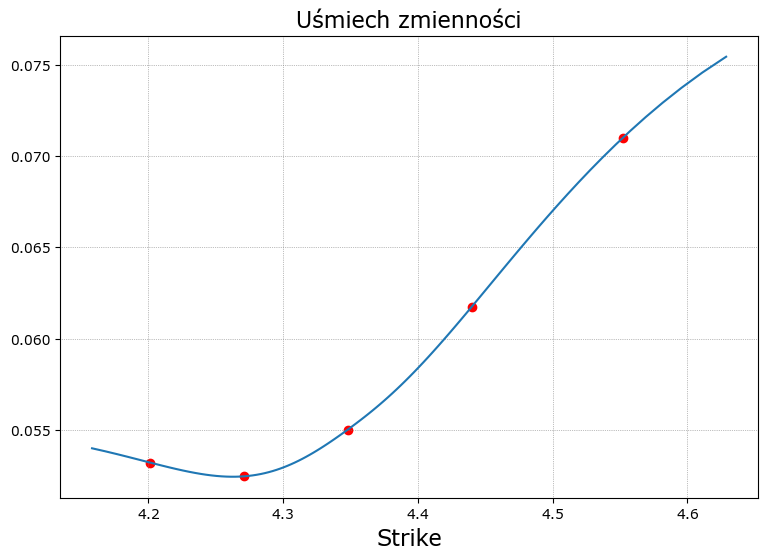

In [24]:
FXspot = 4.3240
dni    = 92
T      = dni/365.0
df_pln_T = if2.int_df(T,yf,df_pln)
df_eur_T = if2.int_df(T,yf,df_eur)
vol_ATM = 0.055
vol_25RR  = 0.0093
vol_25BF  = 0.0021
vol_10RR = 0.0178
vol_10BF = 0.0071
vol25P=vol_ATM-0.5*vol_25RR+vol_25BF
vol25C=vol_ATM+0.5*vol_25RR+vol_25BF
vol10P=vol_ATM-0.5*vol_10RR+vol_10BF
vol10C=vol_ATM+0.5*vol_10RR+vol_10BF
vols=[vol10P,vol25P,vol_ATM,vol25C,vol10C]
intCS=CubicSpline(deltas,vols)
vol=intCS(0.3)
print(vol)
delta_ax=np.linspace(0.05,0.95,100)

# 10RR Strikes
omega = 1
delta = 0.10
K_10C_RR = if2.StrikeFromDelta(spot_fwd,prem_incl,omega,delta,FXspot,vol10C,df_pln_T,df_eur_T,T)
omega = -1
delta = -0.10
K_10P_RR = if2.StrikeFromDelta(spot_fwd,prem_incl,omega,delta,FXspot,vol10P,df_pln_T,df_eur_T,T)

strikes=[K_10P_RR,K_25P_RR,K_ATM,K_25C_RR,K_10C_RR]
strike_ax=np.zeros(100)

fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Uśmiech zmienności",fontsize=16)
axl.set_xlabel("$\Delta$",fontsize=16)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.scatter(deltas,vols,color="red",label='Vols')
plt.plot(delta_ax,intCS(delta_ax))

for k in range(len(strike_ax)):
    if delta_ax[k]<=0.50:
        strike_ax[k] = if2.StrikeFromDelta(spot_fwd,prem_incl,-1,-delta_ax[k],FXspot,intCS(delta_ax[k]),df_pln_T,df_eur_T,T)
    else:
        strike_ax[k] = if2.StrikeFromDelta(spot_fwd,prem_incl,1,1.0-delta_ax[k],FXspot,intCS(delta_ax[k]),df_pln_T,df_eur_T,T)

fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Delta vs Strike",fontsize=16)
axl.set_xlabel("Strike",fontsize=16)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.scatter(strikes,deltas,color="red",label='Deltas')
plt.plot(strike_ax,delta_ax)

volsK = intCS(delta_ax)
fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Uśmiech zmienności",fontsize=16)
axl.set_xlabel("Strike",fontsize=16)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.scatter(strikes,vols,color="red",label='Vols')
plt.plot(strike_ax,volsK)

In [19]:
K = 4.50
omega = -1
def SigmaForStrike(Strike,T,omega,FXspot,df_pln_T,df_eur_T,deltas,vols):
    intCS=CubicSpline(deltas,vols)
    sig=vols[2]
    sig1=sig+0.1
    eps=0.001
    Nmax=10
    n=1
    while abs(sig1-sig) > eps and n < Nmax:
        sig1   = sig
        delta1 = abs(if2.DeltaBS(-1,FXspot, sig1, df_pln_T, df_eur_T, Strike, T, 1))/df_eur_T
        sig    = intCS(delta1)
        n+=1
    return sig, delta1

sigK, delK = SigmaForStrike(K,T,omega,FXspot,df_pln_T,df_eur_T,deltas,vols)
print(sigK,delK)

0.06694978771794555 0.8448676699401447
